In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum
# from pynrc.obs_nircam import model_to_hdulist, obs_hci
# from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import do_plot_contrasts
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

In [18]:
def plot_compare2(curves_all, obs_dict, filt_keys, wfe_list, age, nsig=5, dmax=[0,0],
                  label1='Direct Imaging', label2='Coronagraphy', xr=[0,5], **kwargs):

    fig, axes = plt.subplots(1,2, figsize=(13,5))

    lin_vals = np.linspace(0.2,0.8,len(wfe_list))
    c1 = plt.cm.Blues_r(lin_vals)
    c2 = plt.cm.Reds_r(lin_vals)
    c3 = plt.cm.Purples_r(lin_vals)
    c4 = plt.cm.Greens_r(lin_vals)


    # Left plot (5-sigma sensitivities)
    ax = axes[0]
    yr = [24,8]

    k = filt_keys[0]
    curves = curves_all[k]
    obs = obs_dict[k]
    ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=dmax[0],
                                  ax=ax, colors=c1, xr=xr, yr=yr, return_axes=True)
    # Planet mass locations
    plot_planet_patches(ax, obs, age=age, update_title=True, **kwargs)

    k = filt_keys[1]
    curves = curves_all[k]
    obs = None
    plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=dmax[1], 
                   ax=ax, xr=xr, yr=yr, colors=c2)



    # Right plot (Converted to MJup)
    ax = axes[1]
    k = filt_keys[0]
    curves = curves_all[k]
    obs = obs_dict[k]
    ax, ax3 = plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=dmax[0], 
                             ax=ax, colors=c1, xr=xr, twin_ax=True, return_axes=True)

    k = filt_keys[1]
    curves = curves_all[k]
    obs = obs_dict[k]
    plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=dmax[1], 
                        ax=ax, colors=c2, xr=xr)

    ax.set_title('{} Mass Sensitivities -- COND Models'.format(obs.filter))

    
    # Some fancy log+linear plotting
    from matplotlib.ticker import FixedLocator, ScalarFormatter
    ax = axes[1]
    ax.set_ylim([0,100])
    yr = ax.get_ylim()
    ax.set_yscale('symlog', linthreshy=10, linscaley=2)
    ax.set_yticks(list(range(0,10)) + [10,100,1000])
    ax.yaxis.set_major_formatter(ScalarFormatter())

    minor_log = list(np.arange(20,100,10)) + list(np.arange(200,1000,100))
    minorLocator = FixedLocator(minor_log)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylim([0,yr[1]])


    # Left legend
    nwfe = len(wfe_list)
    ax=axes[0]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h3 = handles[2*nwfe:]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    handles_new = h1_t + h1 + h2_t + h2 + h3
    ax.legend(ncol=3, handles=handles_new, loc=1, fontsize=9)

    # Right legend
    ax=axes[1]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    handles_new = h1_t + h1 + h2_t + h2
    ax.legend(ncol=2, handles=handles_new, loc=1, fontsize=9)



    # Title
    dist = obs.distance
    age_str = 'Age = {:.0f} Myr'.format(age)
    dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''
    title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

    fig.suptitle(title_str, fontsize=16);

    fig.tight_layout()
    fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.97)

    return (fig, axes)

In [19]:
from pynrc.nb_funcs import update_yscale
def do_plot_contrasts2(key1, key2, curves_all, nsig, obs_dict, wfe_list, age, sat_dict=None,
                       label1='Curves1', label2='Curves2', xr=[0,5], yr=[24,8], 
                       yscale2='symlog', yr2=None, av_vals=[0,10], **kwargs):

    fig, axes = plt.subplots(1,2, figsize=(13,5))

    lin_vals = np.linspace(0.2,0.8,len(wfe_list))
    c1 = plt.cm.Blues_r(lin_vals)
    c2 = plt.cm.Reds_r(lin_vals)
    c3 = plt.cm.Purples_r(lin_vals)
    c4 = plt.cm.Greens_r(lin_vals)

    # Left plot (5-sigma sensitivities)
    ax = axes[0]

    k = key1
    curves = curves_all[k]
    obs = obs_dict[k]
    sat_rad = None if sat_dict is None else sat_dict[k]
    ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=sat_rad,
                                  ax=ax, colors=c1, xr=xr, yr=yr, return_axes=True)
    # Planet mass locations
    plot_planet_patches(ax, obs, age=age, update_title=True, av_vals=av_vals, **kwargs)

    if key2 is not None:
        k = key2
        curves = curves_all[k]
        obs = None
        sat_rad = None if sat_dict is None else sat_dict[k]
        plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=sat_rad, 
                       ax=ax, xr=xr, yr=yr, colors=c2)



    # Right plot (Converted to MJup)
    ax = axes[1]
    k = key1
    curves = curves_all[k]
    obs = obs_dict[k]
    sat_rad = None if sat_dict is None else sat_dict[k]
    ax, ax3 = plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=sat_rad, 
                             ax=ax, colors=c1, xr=xr, twin_ax=True, return_axes=True)

    if key2 is not None:
        k = key2
        curves = curves_all[k]
        obs = obs_dict[k]
        sat_rad = None if sat_dict is None else sat_dict[k]
        plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=sat_rad, 
                            ax=ax, colors=c2, xr=xr)

    ax.set_title('Mass Sensitivities -- COND Models')

    # Update fancing y-axis scaling on right plot
    ax = axes[1]
    update_yscale(ax, yscale2, ylim=yr2)

    # Left legend
    nwfe = len(wfe_list)
    ax=axes[0]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h3 = handles[2*nwfe:]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    h3_t = [mpatches.Patch(color='none', label='SB12 Models')]
    if key2 is not None:
        handles_new = h1_t + h1 + h2_t + h2 + h3_t + h3
        ncol = 3
    else:
        h3 = handles[nwfe:]
        handles_new = h1_t + h1 + h3_t + h3
        ncol = 2
    ax.legend(ncol=ncol, handles=handles_new, loc=1, fontsize=9)

    # Right legend
    ax=axes[1]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    if key2 is not None:
        handles_new = h1_t + h1 + h2_t + h2
        ncol = 2
    else:
        handles_new = h1_t + h1
        ncol = 1
    ax.legend(ncol=ncol, handles=handles_new, loc=1, fontsize=9)



    # Title
    dist = obs.distance
    age_str = 'Age = {:.0f} Myr'.format(age)
    dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''
    title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

    fig.suptitle(title_str, fontsize=16);

    fig.tight_layout()
    fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.97)

    return (fig, ([axes[0], ax2, ax3], axes[1]))

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [61]:
#                source,      dist, age, sptype,  vmag kmag  W1   W2
args_sources = [('SAO 206462', 135,  10, 'F8V',   8.7, 5.8, 5.0, 4.0),
                ('TW Hya',      60,  10, 'M0V',  11.0, 7.3, 7.0, 6.9),
                ('MWC 758',    160,   5, 'A5V',   8.3, 5.7, 4.6, 3.5), # Lazareff et al. (2016)
                ('HL Tau',     140,   5, 'K5V',  15.1, 7.4, 5.2, 3.3),
                ('PDS 70',     113, 5.4,'K7IV',  12.2, 8.8, 8.0, 7.7)]

ref_sources = args_sources

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'YSOs/'

In [7]:
# List of filters
args_filter = [('F410M',       None,       None),
               ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## SAO 206462

In [8]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[0.5,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

# Final reference spectrum
sp_ref = sp_sci

[1.83711352e-01 2.70374786e+03 1.49556410e+00]


In [9]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

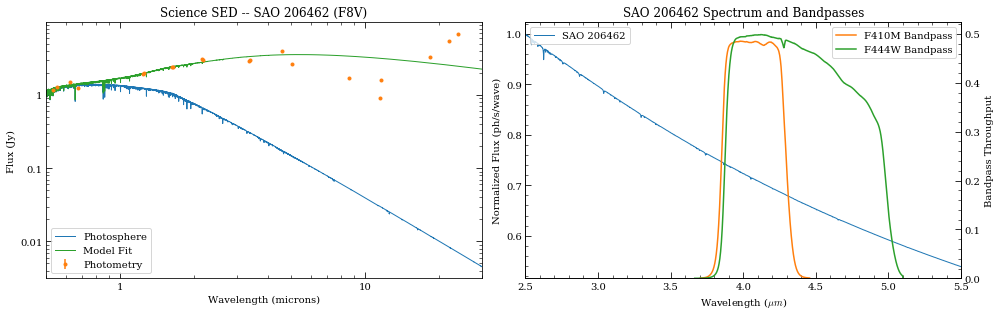

In [12]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [13]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [15]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F410M_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1337.472, 't_acq': 1473.696, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 21.93 vegamag
Surface Brightness Sensitivity (5-sigma): 19.76 vegamag/arcsec^2

F444W_MASK335R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1571.4887999999999, 't_acq': 1587.8232, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.75 vegamag/arcsec^2



### Saturation 

In [16]:
# Max Saturation Values
dmax = []
sat_dict = {}
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)
    sat_dict[k] = dsat_asec


F410M_none_none
Sci: SAO 206462
  60 saturated pixel at NGROUP=2; Max Well: 64.41
  136 saturated pixel at NGROUP=10; Max Well: 322.04
  Sat Dist NG=2: 0.32 arcsec
Ref: SAO 206462
  60 saturated pixel at NGROUP=2; Max Well: 64.41
  136 saturated pixel at NGROUP=10; Max Well: 322.04

F444W_MASK335R_CIRCLYOT
Sci: SAO 206462
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.68
  Sat Dist NG=2: 0.00 arcsec
Ref: SAO 206462
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.68


### Roll Subtraction Curves

In [17]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [38]:
from importlib import reload
reload(pynrc)

# Delete classes/modules to reload
import sys
del sys.modules['pynrc.nb_funcs'] 

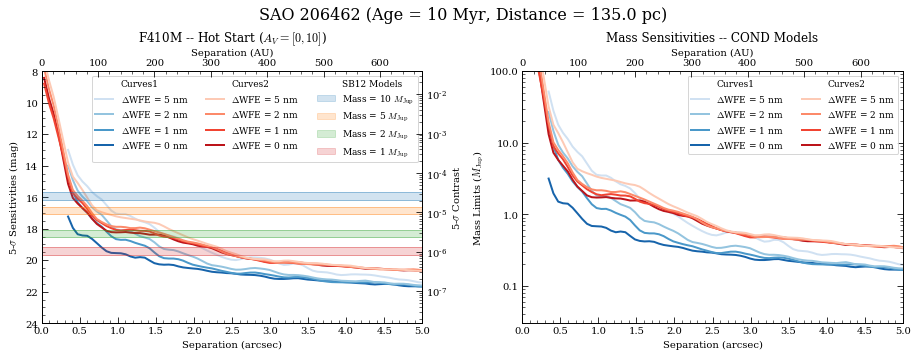

In [27]:
key1, key2 = filt_keys
fig, axes_all = do_plot_contrasts2(key1, key2, curves_noref, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, yr=[24,8], yscale2='log', yr2=[3e-2, 100])

# fig, axes = plot_compare2(curves_noref, obs_dict, filt_keys, wfe_list, age_sci, nsig=nsig, dmax=dmax)

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## TW Hya

In [28]:
# Fit spectrum to SED photometry
i=1
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,30], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[5.46436943e-02 4.64549841e+02 2.59364875e+00]


In [29]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

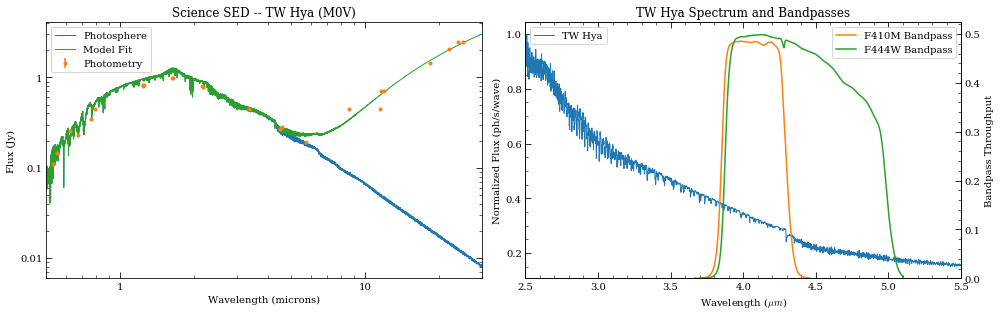

In [30]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [31]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [32]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,160,160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')

### Saturation 

In [33]:
# Max Saturation Values
dmax = []
sat_dict = {}
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)
    sat_dict[k] = dsat_asec


F410M_none_none
Sci: TW Hya
  46 saturated pixel at NGROUP=2; Max Well: 39.72
  67 saturated pixel at NGROUP=5; Max Well: 99.31
  Sat Dist NG=2: 0.32 arcsec
Ref: TW Hya
  46 saturated pixel at NGROUP=2; Max Well: 39.72
  67 saturated pixel at NGROUP=5; Max Well: 99.31

F444W_MASK335R_CIRCLYOT
Sci: TW Hya
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
Ref: TW Hya
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


### Roll Subtraction Curves

In [34]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F410M_none_none
F444W_MASK335R_CIRCLYOT


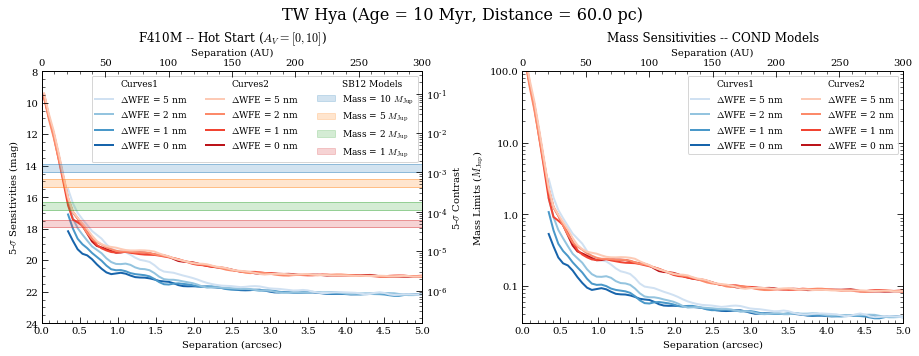

In [35]:
key1, key2 = filt_keys
fig, axes_all = do_plot_contrasts2(key1, key2, curves_noref, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, yr=[24,8], yscale2='log', yr2=[3e-2, 100])

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## MWC 758

In [37]:
# Fit spectrum to SED photometry
i=2
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[6.89562121e-02 3.83155695e+03 2.00704053e+00]


In [38]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

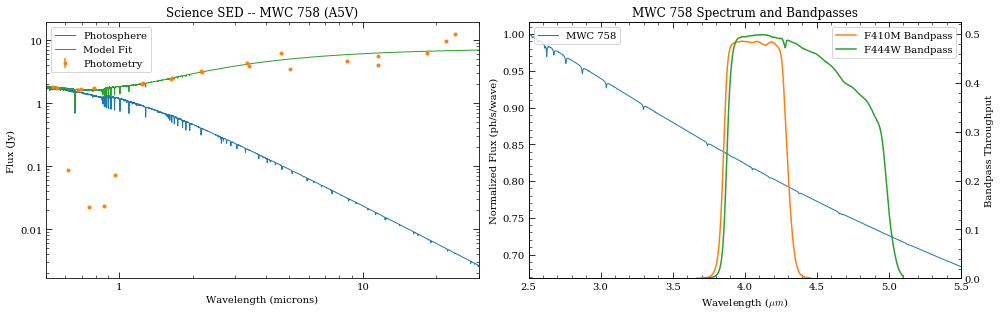

In [39]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [40]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [41]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

### Saturation 

In [42]:
# Max Saturation Values
dmax = []
sat_dict = {}
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)
    sat_dict[k] = dsat_asec


F410M_none_none
Sci: MWC 758
  66 saturated pixel at NGROUP=2; Max Well: 85.03
  171 saturated pixel at NGROUP=10; Max Well: 425.17
  Sat Dist NG=2: 0.32 arcsec
Ref: MWC 758
  66 saturated pixel at NGROUP=2; Max Well: 85.03
  171 saturated pixel at NGROUP=10; Max Well: 425.17

F444W_MASK335R_CIRCLYOT
Sci: MWC 758
  0 saturated pixel at NGROUP=2; Max Well: 0.17
  1 saturated pixel at NGROUP=10; Max Well: 0.92
  Sat Dist NG=2: 0.00 arcsec
Ref: MWC 758
  0 saturated pixel at NGROUP=2; Max Well: 0.17
  1 saturated pixel at NGROUP=10; Max Well: 0.92


### Roll Subtraction Curves

In [43]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F410M_none_none
F444W_MASK335R_CIRCLYOT


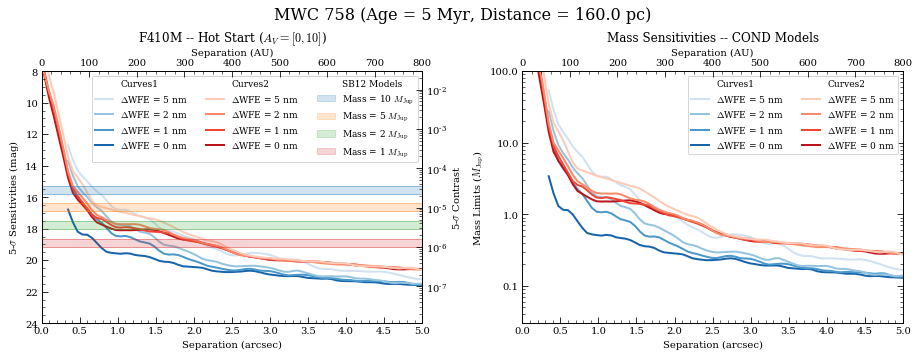

In [44]:
key1, key2 = filt_keys
fig, axes_all = do_plot_contrasts2(key1, key2, curves_noref, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, yr=[24,8], yscale2='log', yr2=[3e-2, 100])

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## HL Tau

In [45]:
# Fit spectrum to SED photometry
i=3
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[0.1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[5.87239779e-01 1.32491541e+03 1.76804276e+00]


In [46]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

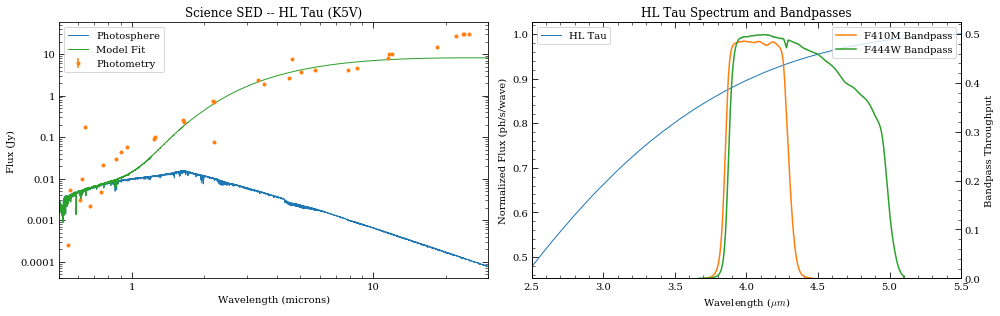

In [47]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [48]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [49]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

### Saturation 

In [50]:
# Max Saturation Values
dmax = []
sat_dict = {}
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)
    sat_dict[k] = dsat_asec


F410M_none_none
Sci: HL Tau
  56 saturated pixel at NGROUP=2; Max Well: 56.78
  127 saturated pixel at NGROUP=10; Max Well: 283.91
  Sat Dist NG=2: 0.32 arcsec
Ref: HL Tau
  56 saturated pixel at NGROUP=2; Max Well: 56.78
  127 saturated pixel at NGROUP=10; Max Well: 283.91

F444W_MASK335R_CIRCLYOT
Sci: HL Tau
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.68
  Sat Dist NG=2: 0.00 arcsec
Ref: HL Tau
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.68


### Roll Subtraction Curves

In [51]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F410M_none_none
F444W_MASK335R_CIRCLYOT


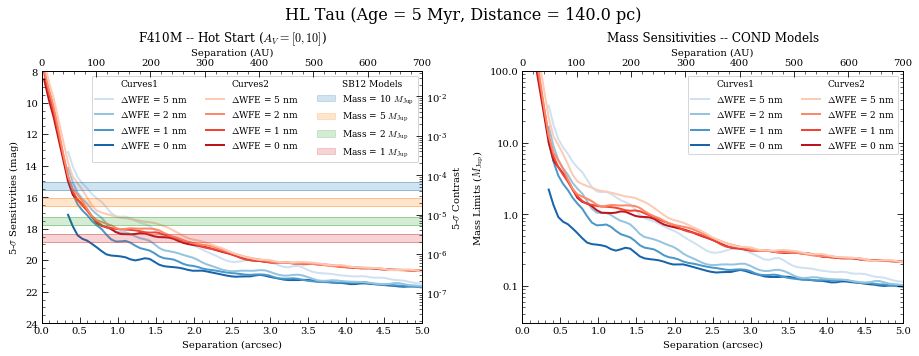

In [52]:
key1, key2 = filt_keys
fig, axes_all = do_plot_contrasts2(key1, key2, curves_noref, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, yr=[24,8], yscale2='log', yr2=[3e-2, 100])

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

## PDS 70

In [62]:
# Fit spectrum to SED photometry
i=4
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[2.62066110e-08 1.06733367e+07 3.54856009e+00]


In [54]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

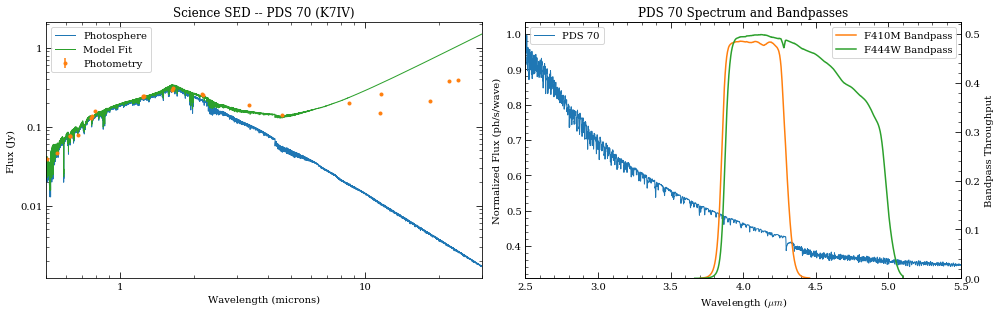

In [55]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (ph/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [56]:
# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')
args_disk = None
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F410M_none_none
F444W_MASK335R_CIRCLYOT


In [57]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,480,480)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')

### Saturation 

In [58]:
# Max Saturation Values
dmax = []
sat_dict = {}
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    dmax.append(dsat_asec)
    sat_dict[k] = dsat_asec


F410M_none_none
Sci: PDS 70
  5 saturated pixel at NGROUP=2; Max Well: 2.66
  13 saturated pixel at NGROUP=10; Max Well: 13.32
  Sat Dist NG=2: 0.10 arcsec
Ref: PDS 70
  5 saturated pixel at NGROUP=2; Max Well: 2.66
  13 saturated pixel at NGROUP=10; Max Well: 13.32

F444W_MASK335R_CIRCLYOT
Sci: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.03
  Sat Dist NG=2: 0.00 arcsec
Ref: PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.03


### Roll Subtraction Curves

In [59]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F410M_none_none
F444W_MASK335R_CIRCLYOT


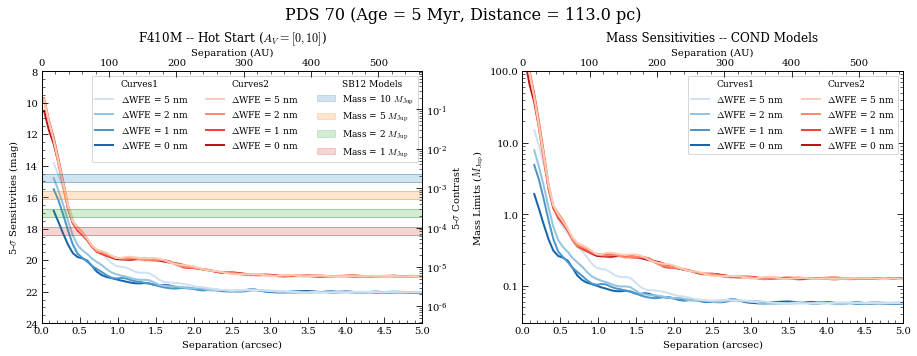

In [63]:
key1, key2 = filt_keys
fig, axes_all = do_plot_contrasts2(key1, key2, curves_noref, nsig, obs_dict, wfe_list, age_sci,
                                   sat_dict=sat_dict, yr=[24,8], yscale2='log', yr2=[3e-2, 100])

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)